In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "4"
import numpy as np
import PIL
import PIL.Image
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [2]:
os.listdir('model_lfw/')

['checkpoint',
 'shallow_model.h5py.data-00000-of-00001',
 'shallow_model.h5py.index']

In [3]:
img_height = 128
img_width = 128
batch_size = 64

In [4]:
data_dir = 'Data/img_align_celeba/*.jpg'
list_ds = tf.data.Dataset.list_files(data_dir, shuffle=False)
for f in list_ds.take(5):
    print(f.numpy())

2023-04-18 11:48:33.743913: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-18 11:48:34.386617: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11414 MB memory:  -> device: 0, name: NVIDIA TITAN Xp, pci bus id: 0000:83:00.0, compute capability: 6.1


b'../../Datasets/CelebA/img_align_celeba/000001.jpg'
b'../../Datasets/CelebA/img_align_celeba/000002.jpg'
b'../../Datasets/CelebA/img_align_celeba/000003.jpg'
b'../../Datasets/CelebA/img_align_celeba/000004.jpg'
b'../../Datasets/CelebA/img_align_celeba/000005.jpg'


2023-04-18 11:48:34.985126: W tensorflow/core/data/root_dataset.cc:167] Optimization loop failed: Cancelled: Operation was cancelled


In [5]:
image_count = len(list_ds)
train_size = int(image_count * 0.6)
val_size = int(image_count * 0.2)
test_size = int(image_count * 0.2)
train_ds = list_ds.take(train_size)
val_ds = list_ds.skip(train_size).take(val_size)
test_ds = list_ds.skip(train_size+val_size).take(test_size)
print("number of training data:", tf.data.experimental.cardinality(train_ds).numpy())
print("number of validating data:", tf.data.experimental.cardinality(val_ds).numpy())
print("number of testing data:", tf.data.experimental.cardinality(test_ds).numpy())

number of training data: 121559
number of validating data: 40519
number of testing data: 40519


In [6]:
def decode_img(img):
    img = tf.io.decode_jpeg(img, channels=3)
    return tf.image.resize(img, [img_height, img_width])

def process_path(file_path):
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, img

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)

In [7]:
def make_generator_model(input_shape):
    model = tf.keras.Sequential()
    model.add(layers.Conv2DTranspose(64, (5, 5), strides = 2, padding='same', use_bias=False, activation='selu', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=2, padding='same', use_bias=False, activation='selu'))
    return model

encoder = tf.keras.applications.resnet50.ResNet50(
            input_shape = (224,224,3), 
            weights = 'imagenet', 
            include_top = False, 
            pooling = 'avg'
        )

encoder = tf.keras.applications.resnet50.ResNet50(
            input_shape = (img_height,img_width,3), 
            weights = 'imagenet', 
            include_top = False, 
            pooling = 'avg'
        ).layers[:7]

encoder = tf.keras.Sequential(encoder)
encoder.summary()
encoder.layers[-1].output_shape[1:]

class Autoencoder(tf.keras.Model):
    def __init__(self, layer):
        super(Autoencoder, self).__init__() 
        self.encoder = tf.keras.applications.resnet50.ResNet50(
            input_shape = (img_height,img_width,3), 
            weights = 'imagenet', 
            include_top = False, 
            pooling = 'avg'
        ).layers[:layer]
        self.encoder = tf.keras.Sequential(self.encoder)
        self.encoder.trainable = False
        self.decoder = make_generator_model(self.encoder.layers[-1].output_shape[1:])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Autoencoder(7)
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss=tf.keras.losses.MeanSquaredError())
autoencoder.build((1,img_height,img_width,3))
autoencoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_pad (ZeroPadding2D)    (None, 134, 134, 3)       0         
_________________________________________________________________
conv1_conv (Conv2D)          (None, 64, 64, 64)        9472      
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 64)        256       
_________________________________________________________________
conv1_relu (Activation)      (None, 64, 64, 64)        0         
_________________________________________________________________
pool1_pad (ZeroPadding2D)    (None, 66, 66, 64)        0         
_________________________________________________________________
pool1_pool (MaxPooling2D)    (None, 32, 32, 64)        0         
Total params: 9,728
Trainable params: 9,600
Non-trainable params: 128
____________________________________________________

In [8]:
model = make_generator_model((32,32,64))
model.load_weights('model_lfw/shallow_model.h5py')
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose_2 (Conv2DTr (None, 64, 64, 64)        102400    
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 128, 128, 3)       4800      
Total params: 107,456
Trainable params: 107,328
Non-trainable params: 128
_________________________________________________________________


In [9]:
considered_images = []
plain_feature = []
for img, label in val_ds.take(1):
    image = img.numpy()
    for i in range(10):
        temp_img = image[i]
        considered_images.append(temp_img)
        temp_img = np.expand_dims(temp_img, axis=0)
        feat = encoder.predict(temp_img) 
        plain_feature.append(feat)

2023-04-18 11:48:38.767588: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-04-18 11:48:39.607742: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8201
2023-04-18 11:48:40.756542: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [10]:
print(len(plain_feature))
print(plain_feature[0].shape)
# model.summary()
plain_feature = np.vstack(plain_feature)
print(type(plain_feature))
print(plain_feature.shape)

10
(1, 32, 32, 64)
<class 'numpy.ndarray'>
(10, 32, 32, 64)


In [11]:
def fairRR_exp(arr, eps, num_int, mode = 'dp'):
    r = arr.shape[1]
    num_pt = arr.shape[0]
    
    max_ = np.max(arr)
    min_ = np.min(arr)
    arr = (arr-min_)/(max_ - min_) * (2**num_int - 1)
    
    int_arr = arr.astype(int)
    print(f'Max int {np.max(int_arr)}, Min int {np.min(int_arr)}')
    frac = arr - int_arr
    num_bit = num_int + 1
    
    
    def float_to_binary(x, m=num_int, n=0):
        x_abs = np.abs(x)
        x_scaled = round(x_abs * 2 ** n)
        res = '{:0{}b}'.format(x_scaled, m + n)
        if x >= 0:
            res = '0' + res
        else:
            res = '1' + res
        return res

    # binary to float
    def binary_to_float(bstr, m=num_int, n=0):
        sign = bstr[0]
        bs = bstr[1:]
        res = int(bs, 2) / 2 ** n
        if int(sign) == 1:
            res = -1 * res
        return res

    def string_to_int(a):
        bit_str = "".join(x for x in a)
        return np.array(list(bit_str)).astype(int)

    def join_string(a, num_bit=num_bit, num_feat=r):
        res = np.empty(num_feat, dtype="S10")
        # res = []
        for i in range(num_feat):
            # res.append("".join(str(x) for x in a[i*l:(i+1)*l]))
            res[i] = "".join(str(x) for x in a[i * num_bit:(i + 1) * num_bit])
        return res
    
    def alpha_tr1(r, eps, l):
        return np.exp( ( eps - r*eps*(l-1) ) /(2*r*l) )

    def alpha(r, eps, l):
        nu = 2*( np.sqrt( 6*np.log(10) /(2*r) ) )
        sum_ = 0
        for k in range(l):
            sum_ += np.exp(2 * eps*k / l)
        return np.sqrt(((1-nu)*eps + r*l) / (2*r * sum_))

    alpha_ = alpha_tr1(r=r, eps=eps, l=num_bit) if mode == 'dp' else alpha(r=r, eps=eps, l=num_bit)
    
    float_to_binary_vec = np.vectorize(float_to_binary)
    binary_to_float_vec = np.vectorize(binary_to_float)
    
    feat_tmp = float_to_binary_vec(int_arr)
    feat = np.apply_along_axis(string_to_int, 1, feat_tmp)
    index_matrix = np.array(range(num_bit))
    p = 1 / (1 + alpha_ * np.exp(index_matrix * eps / num_bit))
    print(p)
    index_matrix = np.tile(index_matrix, (num_pt, r))
    p = 1 / (1 + alpha_ * np.exp(index_matrix * eps / num_bit))
    p_temp = np.random.rand(p.shape[0], p.shape[1])
    perturb = (p_temp > p).astype(int)
    print(feat[0][:num_bit])
    print(perturb[0][:num_bit])
    perturb_feat = (perturb + feat) % 2
    print(perturb_feat[0][:num_bit])
    perturb_feat = np.apply_along_axis(join_string, 1, perturb_feat)
    perturb_feat = binary_to_float_vec(perturb_feat)
    print(int_arr[0][:2])
    print(perturb_feat[0][:2])
    perturb_feat = perturb_feat + frac
    perturb_feat = perturb_feat/(2**num_int - 1)*(max_ - min_) + min_
    return perturb_feat

In [12]:
plain_feature.shape

(10, 32, 32, 64)

In [13]:
temp_plain = np.reshape(plain_feature, newshape=(plain_feature.shape[0], plain_feature.shape[1]*plain_feature.shape[2]*plain_feature.shape[3]))

In [14]:
perturb_feat = fairRR_exp(arr=temp_plain, eps=10.0, num_int=5, mode = 'relax')

Max int 31, Min int 0
[0.99959132 0.99784006 0.9886693  0.94279339 0.7568545  0.37024739]
[0 0 0 0 1 1]
[0 0 0 0 0 1]
[0 0 0 0 1 0]
[3 0]
[2. 0.]


In [15]:
perturb_matrix = np.reshape(perturb_feat, newshape=plain_feature.shape)

In [16]:
pred_img = model.predict(np.expand_dims(perturb_matrix[0], axis=0))

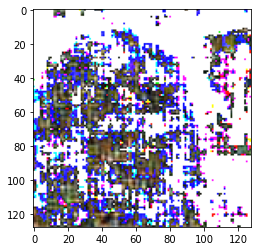

In [17]:
plt.imshow(np.squeeze(pred_img).astype("uint8"))